# Stationary behaviour of EIP 1559 agent-based model

###### July 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

We introduce here the building blocks of agent-based simulations of EIP1559. This follows an [earlier notebook](https://nbviewer.jupyter.org/github/ethereum/rig/blob/master/eip1559/eip1559.ipynb) that merely looked at the dynamics of the EIP 1559 mechanism. In the present notebook, agents decide on transactions based on the current basefee and form their transactions based on internal evaluations of their values and costs.

All the code is available in [this repo](https://github.com/barnabemonnot/abm1559), with some preliminary documentation [here](https://barnabemonnot.com/abm1559/build/html/). You can also download the [`abm1559` package from PyPi](https://pypi.org/project/abm1559/) and reproduce all the analysis here yourself!

## The broad lines

We have several entities. _Users_ come in randomly (following a Poisson process) and create and send transactions. The transactions are received by a _transaction pool_, from which the $x$ best _valid_ transactions are included in a _block_ created at fixed intervals. $x$ depends on how many valid transactions exist in the pool (e.g., how many post a gasprice exceeding the prevailing basefee in 1559 paradigm) and the block gas limit. Once transactions are included in the block, and the block is included in the _chain_, transactions are removed from the transaction pool.

How do users set their parameters? Users have their own internal ways of evaluating their _costs_. Users obtain a certain _value_ from having their transaction included, which we call $v$. $v$ is different for every user. This value is fixed but their overall _payoff_ decreases the longer they wait to be included. Some users have higher time preferences than others, and their payoff decreases faster than others the longer they wait. Put together, we have the following:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

Users expect to wait for a certain amount of time. In this essay, we set this to a fixed value -- somewhat arbitrarily we chose 5. This can be readily understood in the following way. Users estimate what their payoff will be from getting included 5 blocks from now, assuming basefee remains constant. If this payoff is negative, they decide not to send the transaction to the pool (in queuing terminology, they _balk_). We'll play with this assumption later down in the text.

The scenario is set up this way to study _stationarity_: assuming some demand comes in from a fixed distribution at regular intervals, we must expect basefee to reach some stationary value and stay there. It is then reasonable for users, at this stationary point, to consider that 5 blocks from now basefee will still be at the same level. In the nonstationary case, when for instance a systemic change in the demand happens (e.g., the rate of Poisson arrivals increases, which we'll also simulate), a user may want to hedge their bets by estimating their future payoffs in a different way, taking into account that basefee might increase instead. This strategy would probably be a good idea during the _transition_ phase, when basefee shifts from one stationary point to a new one.

We make the assumption here that users choose their 1559 parameters based on their value alone. We set the transaction `max_fee` parameter to the value of the user and the `gas_premium` parameter is set to a residual value, here 1 Gwei per unit of gas. There is no loss of generality in assuming all users send the same transaction in (e.g., a simple transfer) and so all transactions have the same `gas_used` value (21,000). In 1559 paradigm, with a 20M gas limit per block, this allows at most 952 transactions to be included, although of course the mechanism will target half of that, around 475 here.

## Simulation

We import a few classes from our `abm1559` package.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559, UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_demand,
    decide_transactions,
    update_basefee,
)

import pandas as pd

Below is the main function used to simulate the fee market. It takes in a `demand_scenario` array. We've seen that each round, we draw the number of users wishing to send transactions from a Poisson distribution. [This distribution is parameterised by the expected number of arrivals, called _lambda_ $\lambda$](https://en.wikipedia.org/wiki/Poisson_distribution). The `demand_scenario` array contains a sequence of such lambda's. We also provide in `UserClass` the type of user we would like to model (see the [docs](http://barnabemonnot.com/abm1559/build/html/#users) for more details).

In the remainder, our users will draw their value for the transaction (per Gwei) from a uniform distribution, picking a random number between 0 and 20 (Gwei). Their cost for waiting one extra unit of time is drawn from a uniform distribution too, this time between 0 and 1 (Gwei). The closer their cost is to 1, the more impatient users are.

The numbers above sound arbitrary, and in a sense they are! They were chosen to respect the scales we are used to (although gas prices are closer to 100 Gweis these days...), but any distribution (uniform, Pareto, whatever floats your boat) would lead to stationarity. The important part is that _some_ users have positive value for transacting in the first place, enough to fill a block to its target size at least. The choice of uniform distribution, as opposed to having all users experience the same cost per round, allows for simulating a scenario where some users are more in a hurry than others.

In [2]:
def simulate(demand_scenario, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)
        
        # Add users to the pool
        user_pool.add_users(users)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "timestep": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "blk_avg_waiting_time": block.average_waiting_time(),
            "pool_length": txpool.pool_length,
            "pool_avg_gas_price": txpool.average_gas_price(params),
            "pool_avg_tip": txpool.average_tip(params),
            "pool_avg_waiting_time": txpool.average_waiting_time(t),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

To study the stationary case, we start with an array containing the same value for as many time steps as we wish to simulate the market for. We'll set that value to expecting 2000 users spawning between two blocks, for 200 timesteps.

In [3]:
demand_scenario = [2000 for i in range(200)]
(df, user_pool, chain) = simulate(demand_scenario, User1559)

0
100


## Results

Let's print the head and tail of the data frame holding our metrics. Each row corresponds to one round of our simulation, so one block.

In [4]:
df

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_gas_price,pool_avg_tip,pool_avg_waiting_time
0,0,1.000000,1884,1437,952,2.000000,1.0,0.000000,485,2.000000,1.000000,0.000000
1,1,1.124900,2022,1560,952,2.124900,1.0,0.509454,1093,2.124900,1.000000,0.000000
2,2,1.265400,2049,1599,952,2.265400,1.0,1.000000,1740,2.265400,1.000000,0.081034
3,3,1.423448,1996,1516,952,2.423448,1.0,1.148109,2304,2.423448,1.000000,0.342014
4,4,1.601237,1998,1484,952,2.601237,1.0,1.825630,2836,2.601210,0.999973,0.477433
...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,11.805324,2021,479,479,12.805324,1.0,0.000000,1601,8.671724,-3.133600,181.668332
196,196,11.814031,2057,486,486,12.814031,1.0,0.000000,1601,8.671724,-3.142307,182.668332
197,197,11.844452,1960,484,484,12.844452,1.0,0.000000,1601,8.671724,-3.172728,183.668332
198,198,11.868733,2026,453,453,12.868733,1.0,0.000000,1601,8.671724,-3.197009,184.668332


At the start of the simulation we clearly see in column `users` a demand close to 2000 users per round. Among these 2000 or so, around 1500 decide to send their transaction in (`decided_txs`). The 500 who don't might have a low value or high per-round. costs, deciding that it is unprofitable for them to even send their transaction in. Eventually 952 of them are included (`included_txs`), maxing out the block gas limit. The basefee starts at 1 Gwei but steadily increases from there, reaching around 11.5 Gwei by the end.

By the end of the simulation, we note that `decided_txs` is always equal to `included_txs`. By this point, the basefee has risen enough to make most users find sending their transaction is unprofitable. This is exactly what we want! Users balk at the current prices.

In the next chart we show the evolution of basefee and gas price. We define _tip_ as the gas price minus the basefee. Note that [it is in general **not** equal to the gas premium](https://twitter.com/barnabemonnot/status/1284271520311848960) that users set, in particular when basefee plus gas premium exceeds the max fee of the user. In the graph below, the tip hovers around 1 Gwei (the premium), but is sometimes less than 1 too, especially when users see their posted max fees approached by the prevailing basefee.

<AxesSubplot:xlabel='timestep'>

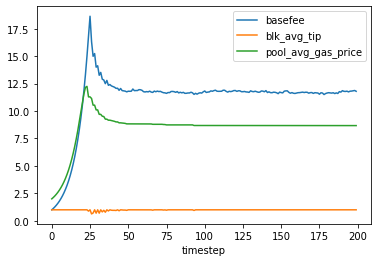

In [5]:
df.plot("timestep", ["basefee", "blk_avg_tip", "pool_avg_gas_price"])

Notice the increase at the beginning followed by a short drop? At the very beginning, the pool fills up quickly with many users hopeful to get their transactions in with a positive resulting payoff. The basefee increases until users start balking **and** the pool is exhausted. Once exhausted, basefee starts decreasing again to settle at the stationary point where the pool only includes transactions that are invalid given the stationary basefee (see also the average gas price of transaction in the pool, with the red line well below the basefee even).

We can see the pool length becoming stationary in the next plot, showing the length of the pool over time.

<AxesSubplot:xlabel='timestep'>

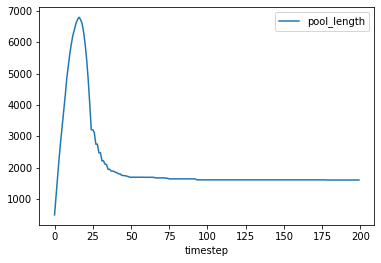

In [6]:
df.plot("timestep", "pool_length")

Remaining transactions are likely from early users who did not balk even though basefee was increasing, and who were quickly outbid by others.

## Demand shock

We look at a stationary setting, where the new demand coming in each new round follows a fixed expected rate of arrival. Demand shocks may be of two kinds:

- Same number of users, different values for transactions and costs for waiting.
- Increased number of users, same values and costs.

We'll consider the second scenario here, simply running the simulation again and increasing the parameter of our Poisson arrival process suddenly, from expecting 2000 users per round to 6000.

In [7]:
demand_scenario = [2000 for i in range(100)] + [6000 for i in range(100)]
(df_jump, user_pool_jump, chain_jump) = simulate(demand_scenario, User1559)

0
100


<AxesSubplot:xlabel='timestep'>

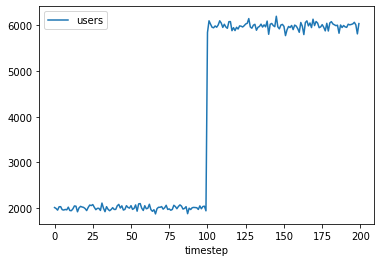

In [8]:
df_jump.plot("timestep", "users")

<AxesSubplot:xlabel='timestep'>

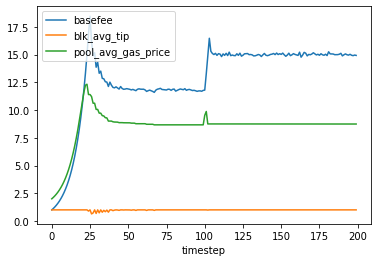

In [9]:
df_jump.plot("timestep", ["basefee", "blk_avg_tip", "pool_avg_gas_price"])

We see a jump around timestep 200, when the arrival rate of users switches from 2000 to 6000. Basefee increases in response. With a block limit of 20M gas, about 950 transactions fit in each block. Targetting half of this value, basefee increases until more or less 475 transactions are included in each block.

Since our users' values and costs are always drawn from the same distribution, we expect when 2000 users show up to let in about 25% of them (~ 475 / 2000), the 25% with greatest expected payoff should they wait 5 blocks to get in. When 6000 users come in, we now expect the 8% (~ 475 / 6000) "richest" to get in only, so we obviously "raise the bar" for the basefee, since we need to discriminate more.

<AxesSubplot:xlabel='timestep'>

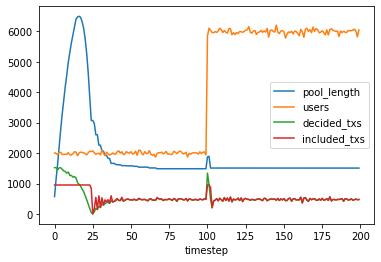

In [10]:
df_jump.plot("timestep", ["pool_length", "users", "decided_txs", "included_txs"])

As we see with the graph above, for a short while blocks include more than the usual ~475 transactions: since we have a whole bunch of new users, more of them are willing and able to pay for their transactions above the basefee, and thus get included.

In [11]:
df_jump.tail()

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_gas_price,pool_avg_tip,pool_avg_waiting_time
195,195,15.030753,6035,454,454,16.030753,1.0,0.0,1507,8.741722,-6.289031,180.42004
196,196,14.943199,6070,467,467,15.943199,1.0,0.0,1507,8.741722,-6.201477,181.42004
197,197,14.907148,6013,490,490,15.907148,1.0,0.0,1507,8.741722,-6.165426,182.42004
198,198,14.961187,5816,468,468,15.961187,1.0,0.0,1507,8.741722,-6.219465,183.42004
199,199,14.929020,6042,476,476,15.929020,1.0,0.0,1507,8.741722,-6.187298,184.42004


## Changing expected time

Up until now, users would decide whether to join the transaction pool or not based on the expectation that they will be included at least 5 blocks after they join. They evaluate their payoff assuming that basefee does not change (stationarity) for these 5 blocks. If their value for transacting minus the cost of waiting for 5 blocks minus the cost of transacting is positive, they send their transactions in!

Under a stationary demand however, we should expect that users can get included in the next block. So let's decrease the time users expect to wait to 1 block only and see what happens. We do this by subclassing our `User1559` agent and overriding its `expected_time` method.

In [12]:
class OptiUser(User1559):
    def expected_time(self, params):
        return 1
    
(df_opti, user_pool_opti, chain_opti) = simulate(demand_scenario, OptiUser)

0
100


<AxesSubplot:xlabel='timestep'>

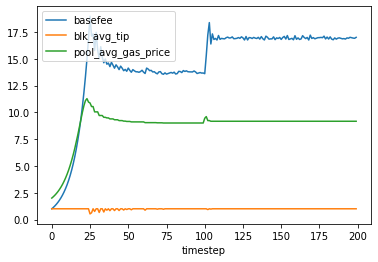

In [13]:
df_opti.plot("timestep", ["basefee", "blk_avg_tip", "pool_avg_gas_price"])

The plot looks the same. But let's look at the average basefee for the last 50 blocks in this scenario and the last.

In [14]:
df_opti[(df.timestep > 150)][["basefee"]].mean()

basefee    16.927808
dtype: float64

In [15]:
df_jump[(df.timestep > 150)][["basefee"]].mean()

basefee    15.01114
dtype: float64

When users expect to be included in the next block rather than wait for at least 5, basefee increases! It makes sense if we come back to our payoff definition:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

The estimated cost for waiting is lower now since users estimate they'll wait 1 block and not 5 to get in. Previously, some users with high values but high time preferences might have been discouraged to join the pool. Now these users don't expect to wait as much, and since their values are high, they don't mind bidding for a higher basefee either. We can check indeed that on average, users included in this last scenario have higher values than users included in the previous one.

To do so, we export to pandas `DataFrame`s the user pool (to obtain their values and costs) and the chain (to obtain the addresses of included users in the last 50 blocks).

In [16]:
user_pool_opti_df = user_pool_opti.export().rename(columns={ "pub_key": "sender" })
chain_opti_df = chain_opti.export()

Let's open these up and see the data we have.

In [17]:
user_pool_opti_df.tail()

,user,sender,value,user_type,cost_per_unit
799402,1559 affine user with value 14929589393 and co...,b'k\x80\x0e2km\xdcK',14929589393,user_1559,182737618
799403,1559 affine user with value 11405991129 and co...,b'\xf5\xa0\x92\x96\xd2\xf5\xbf\x17',11405991129,user_1559,995720785
799404,1559 affine user with value 6583542598 and cos...,b'\x8cJH\xef\x88%w\x9d',6583542598,user_1559,931158394
799405,1559 affine user with value 10506125121 and co...,b'k\x8bII\x81\xf7\xcf\xe7',10506125121,user_1559,248321688
799406,1559 affine user with value 12525573849 and co...,b'\xf2\xbaC\xe4\x95^\x1cA',12525573849,user_1559,128263971


In [18]:
chain_opti_df.tail()

,block_height,tx_index,basefee,tx,start_block,sender,gas_used,tx_hash,gas_premium,max_fee
106891,199,418,16.992274,1559 Transaction 0a09e2015c4d82d4: max_fee 196...,199,b'\xf8\x00\x8bd\xbe \\J',21000,b'\n\t\xe2\x01\\M\x82\xd4',1.0,19.676957
106892,199,419,16.992274,1559 Transaction 45d3bbd5c8f69617: max_fee 197...,199,b'\x14P\xacR:\xb0\xe9U',21000,b'E\xd3\xbb\xd5\xc8\xf6\x96\x17',1.0,19.716928
106893,199,420,16.992274,1559 Transaction dce2619e4dfc3cce: max_fee 187...,199,b't\xc5#\xd0~\xa2\xc8\xce',21000,b'\xdc\xe2a\x9eM\xfc<\xce',1.0,18.706630
106894,199,421,16.992274,1559 Transaction f0a1d2386618e237: max_fee 196...,199,b'W\xb9\x1a\r\x048x\x97',21000,b'\xf0\xa1\xd28f\x18\xe27',1.0,19.661093
106895,199,422,16.992274,1559 Transaction 91d02b9bb46070a9: max_fee 199...,199,b'\xcf\x94\x0bDd\x95\xe3K',21000,b'\x91\xd0+\x9b\xb4`p\xa9',1.0,19.994167


With a simple join on the `sender` column we can associate the value of each user with the transaction. Then we average on this value.

In [19]:
chain_opti_df[(chain_opti_df.block_height >= 150)].join(user_pool_opti_df.set_index("sender"), on="sender")[["value"]].mean()

value    1.918271e+10
dtype: float64

When users expect to be included at least one block after, the average value of included users is around 19.2 Gwei.

In [20]:
user_pool_jump_df = user_pool_jump.export().rename(columns={ "pub_key": "sender" })
chain_jump_df = chain_jump.export()
chain_jump_df[(chain_jump_df.block_height >= 150)].join(user_pool_jump_df.set_index("sender"), on="sender")[["value"]].mean()

value    1.867335e+10
dtype: float64

But when users expect to be included at least _five_ blocks after, the average value of included users is around 18.7 Gwei, confirming that when users expect next block inclusion, higher value users get in and raise the basefee in the process.

## Conclusion

We've looked at 1559 when users with own values and costs decide whether to join the pool or not based on the current basefee level. These users estimate their ultimate payoff by assuming _stationarity_: demand following the same arrival process and same distribution of values and costs comes in between rounds. In this stationary environment, basefee settles on some value and mostly stays there, allowing users to estimate their payoff should they wait for five or one blocks to be included.

We've again left aside some important questions. Here all users simply leave a 1 Gwei premium in their transactions. In reality, we should expect that users would attempt to "game" the system by leaving higher tips to get in first. In a stationary environment however, "gaming" would only be possible until basefee reaches its stationary point (during the transition period) and exhausts the feasible demand. We could simulate this and will leave it for another notebook.

(Temporary) nonstationarity is more interesting. The [5% meme](https://insights.deribit.com/market-research/analysis-of-eip-2593-escalator/) during which sudden demand shocks precipitate large influx of new, high-valued transactions should also see users try to outcompete each other based on premiums alone, until basefee catches up. The question of whether 1559 offers anything in this case or whether the whole situation would look like a first price auction may be better settled empirically, but we can intuit that 1559 would smooth the process slightly by offering a (laggy) price oracle.

And then we have the question of miner collusion, which rightfully agitates a lot of the ongoing conversation. In the simulations we do here, we instantiated one transaction pool only, which should tell you that we are looking at a "centralised", honest miner that includes transactions as much as possible, and not a collection or a cartel of miners cooperating. We can of course weaken this assumption and have several mining pools with their own behaviours and payoff evaluations, much like we modelled our users. We still would like to have a good theoretical understanding of the risks and applicability of miner collusion strategies. Onward!

---

#### (Bonus) Ex post individual rationality

_Individual rationality_ is the idea that agents won't join a mechanism unless they hope to make some positive payoff out of it. I'd rather not transact if my value for transacting minus my costs is negative.

In general, we like this property and we want to make the mechanism individually rational to as many agents as possible. Yet, some mechanisms fail to satisfy _ex post_ individual rationality: I might _expect_ to make a positive payoff from the mechanism, but some _realisation_ of the mechanism exists where my payoff is negative.

Take an auction. As long as my bid is lower or equal to my value for the auctioned item, the mechanism is ex post individually rational for me: I can never "overpay". If I value the item for 10 ETH and decide to bid 11 ETH, in a first-price auction where I pay for my bid if I have the highest, there is a realisation of the mechanism where I am the winner and I am asked to pay 11 ETH. My payoff is -1 ETH then.

In the transaction fee market, ex post individual rationality is not guaranteed unless I can cancel my transaction. In the simulations here, we do not offer this option to our agents. They expect to wait for inclusion for a certain amount of blocks, and evaluate whether their profit after that wait is positive or not to decide whether to send their transaction or not. However, some agents might wait longer than their initial estimation, in particular before the mechanism reaches stationarity. Some realisations of the mechanism then yield a negative profit for these agents, and the mechanism is not ex post individually rational.

Let's look at the agents' payoff using the transcript of transactions included in the chain. For each transaction, we want to find out what was the ultimate payoff for the agent who sent it in. If the transaction was included much later than the agent's initial estimation, this payoff is negative, and the mechanism wasn't ex post individually rational to them.

In [21]:
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })
chain_df = chain.export()
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

In the next chunk we obtain the users' payoff: their value minus the costs incurred from the transaction fee and the time they waited.

In [22]:
user_txs_df["payoff"] = user_txs_df.apply(
    lambda row: row.user.payoff({
        "current_block": row.block_height,
        "gas_price": row.tx.gas_price({
            "basefee": row.basefee * (10 ** 9) # we need basefee in wei
        })
    }) / (10 ** 9), # put payoff is in Gwei
    axis = 1
)
user_txs_df["epir"] = user_txs_df.payoff.apply(
    lambda payoff: payoff >= 0
)

Now we count the fraction of users in each block who received a positive payoff.

In [23]:
epir_df = pd.concat([
    user_txs_df[["block_height", "tx_hash"]].groupby(["block_height"]).agg(["count"]),
    user_txs_df[["block_height", "epir"]][user_txs_df.epir == True].groupby(["block_height"]).agg(["count"])
], axis = 1)
epir_df["percent_epir"] = epir_df.apply(
    lambda row: row.epir / row.tx_hash * 100,
    axis = 1
)

Let's plot it!

<AxesSubplot:xlabel='block_height'>

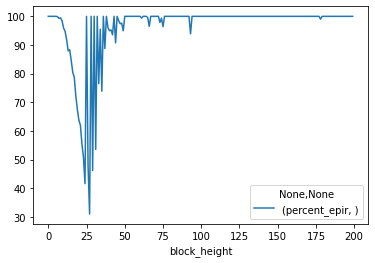

In [24]:
epir_df.reset_index().plot("block_height", ["percent_epir"])

At the very beginning, all users (100%) have positive payoff. They have only waited for 1 block to get included. Steadily this percentage is going down, as basefee increases and some high value users waiting in the pool get included much later than they expected, netting a negative payoff.

Passed the initial instability while basefee is looking for its stationary value, all users receive a positive payoff. This is somewhat expected: once basefee has increased enough to weed out excess demand, users can pretty much guarantee next block inclusion, and so the realised waiting time will always be under their estimation.